In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
# Load data from the folder
DATA_PATH = 'data/elliptic_bitcoin_dataset/'
df_features = pd.read_csv(DATA_PATH+'elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv(DATA_PATH+"elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv(DATA_PATH+"elliptic_txs_classes.csv")

In [11]:
contain_null = lambda df : df.isnull().any().any()
assert(not contain_null(df_features))
assert(not contain_null(df_edges))
assert(not contain_null(df_classes))

In [12]:
# reformat classes 0:licit, 1:illicit, 2:unknown
idx_to_class = ['Licit','Illicit','Unknown']
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0}) 

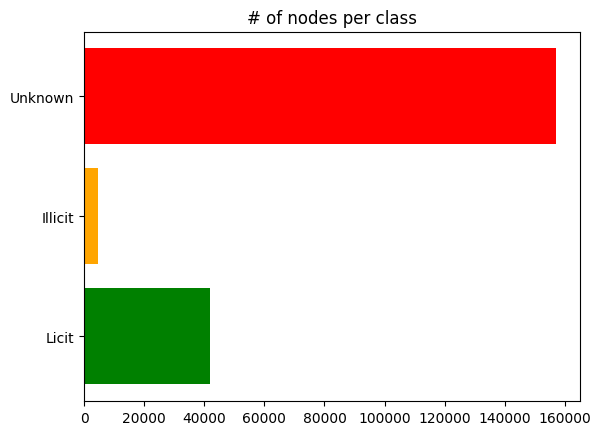

In [13]:
# See repartition of nodes per class
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh(idx_to_class, group_class['txId'].values, color=['g', 'orange', 'r'] )
FOLDERNAME = './save_results/visualization/'
plt.savefig(FOLDERNAME+'class_bargraph.png',format='png')

In [14]:
# View node features
# Data is each node is a transaction ID, and edges are a bit weird, but its like a "previous transaction" edge type
# column 0 = transaction id, column 1 = time step
# first 94 = info of transaction
# remaining 72 = aggregrated
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [15]:
# See edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [16]:
# See classes
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


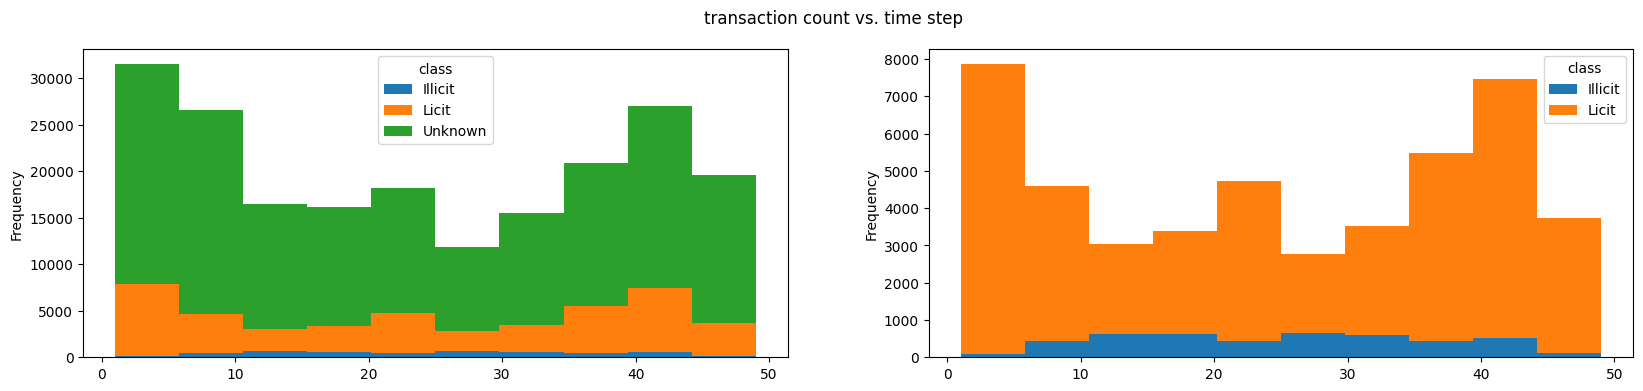

In [17]:
df_tmp = pd.merge(df_features,df_classes,how='left',left_on=0,right_on='txId')[[1,'class']]
df_tmp['class'] = df_tmp['class'].map(lambda i : idx_to_class[i])

fig,axs= plt.subplots(1,2,figsize=(20,4))
fig.suptitle('transaction count vs. time step')
df_tmp.pivot(columns='class')[1].plot(kind = 'hist', stacked=True,ax=axs[0])

df_tmp[df_tmp['class'] != 'Unknown'].pivot(columns='class')[1].plot(kind = 'hist', stacked=True,ax=axs[1])
fig.savefig(FOLDERNAME+'transaction_hist_bargraph.png',format='png')

In [18]:
def construct_graph():
    G = nx.DiGraph()
    
    df_merge = df_edges.merge(df_features,how='left',left_on='txId1',right_on=0)
    
    edges = df_merge[['txId1','txId2',1]]

    edges = edges.values
    edges = [(u,v,{'t':t}) for u,v,t in edges]
    
    G.add_edges_from(edges)
    
    nodes = df_features[[0,1]]
    nodes = nodes.merge(df_classes, how='left',left_on=0,right_on='txId')

    
    nodes = nodes[[0,1,'class']].values
    nodes = [(u,{'t':t,'label':y}) for u,t,y in nodes]
    G.add_nodes_from(nodes)
    return G


G = construct_graph()

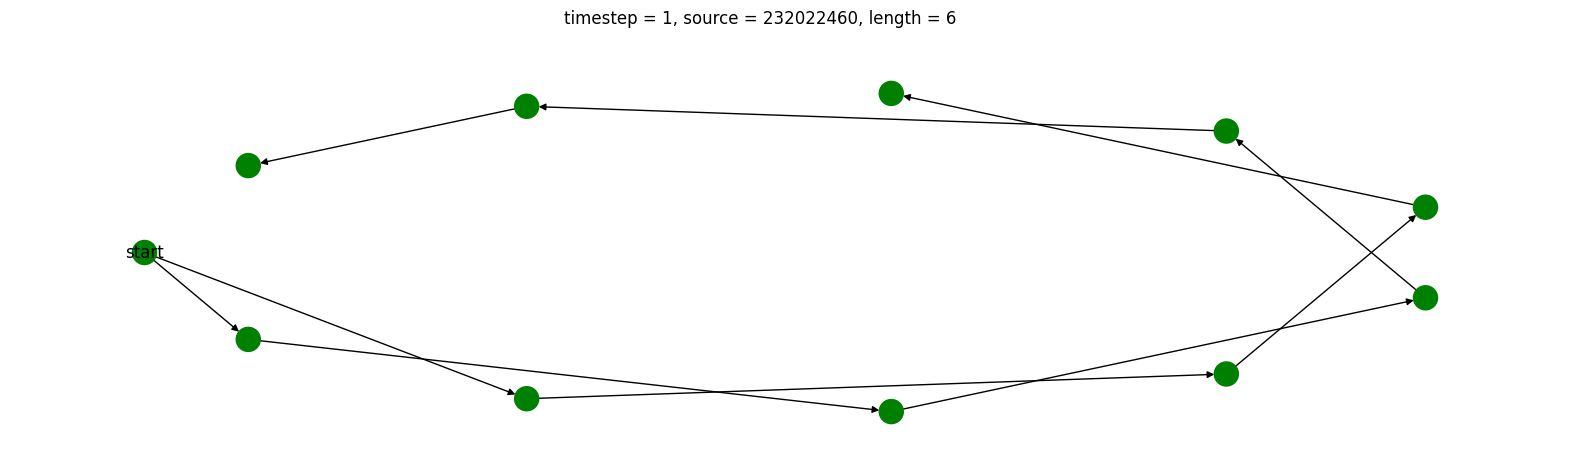

In [39]:
def construct_bfs_tree(G,src):
    g = nx.bfs_tree(G,src)
    g = nx.DiGraph(g)
    attributes = nx.get_edge_attributes(G, 't')
    nx.set_edge_attributes(g, attributes, 't')
    attributes = nx.get_node_attributes(G, 't')
    nx.set_node_attributes(g, attributes, 't')
    
    attributes = nx.get_node_attributes(G, 'label')
    nx.set_node_attributes(g, attributes, 'label')
    return g

def plot_bfs(G,src=None):
    from random import choice

    if src is None:
        src = choice(list(G.nodes))

    g = construct_bfs_tree(G,src)
    
    labels = {n:(n if g.nodes[n]['label'] == 1 else '') for n in g }
    labels[src] = 'start' if g.nodes[src]['label'] != 1 else src
    
    cmap = ['red' if g.nodes[n]['label'] == 1  else 'green' for n in g.nodes]
    pos = nx.shell_layout(g)
    fig,ax = plt.subplots(1,1,figsize=(20,5))
    length = nx.dag_longest_path_length(g)
    fig.suptitle(f'timestep = {g.nodes[src]["t"]}, source = {src}, length = {length}')
    nx.draw(g,pos,node_color=cmap,labels=labels,ax=ax)
    return fig,ax

fig,ax = plot_bfs(G,232022460)
fig.savefig(FOLDERNAME+f'transaction_graph_232022460')

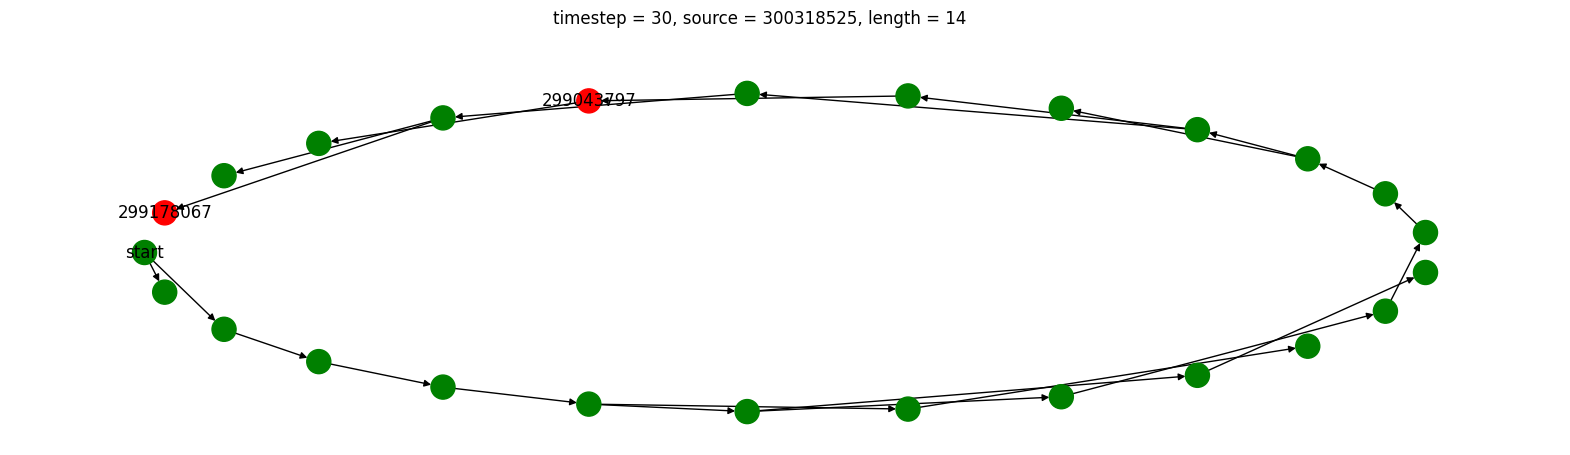

In [41]:
fig,ax = plot_bfs(G,300318525)
fig.savefig(FOLDERNAME+f'transaction_graph_{300318525}')

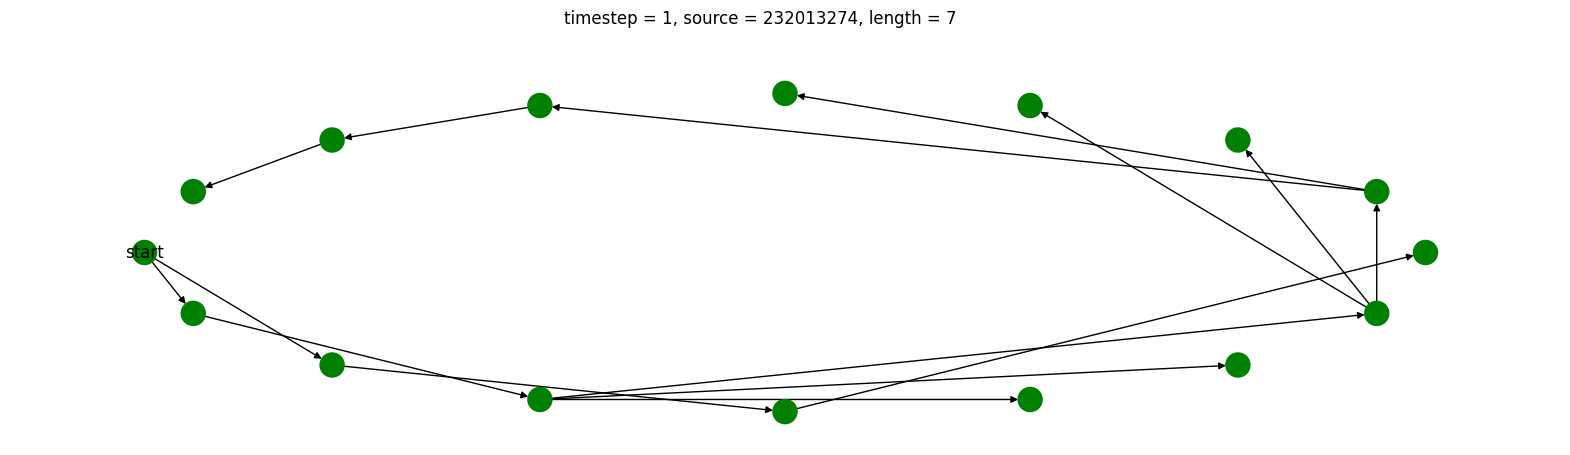

In [42]:
fig,ax = plot_bfs(G,232013274)
fig.savefig(FOLDERNAME+f'transaction_graph_{232013274}')

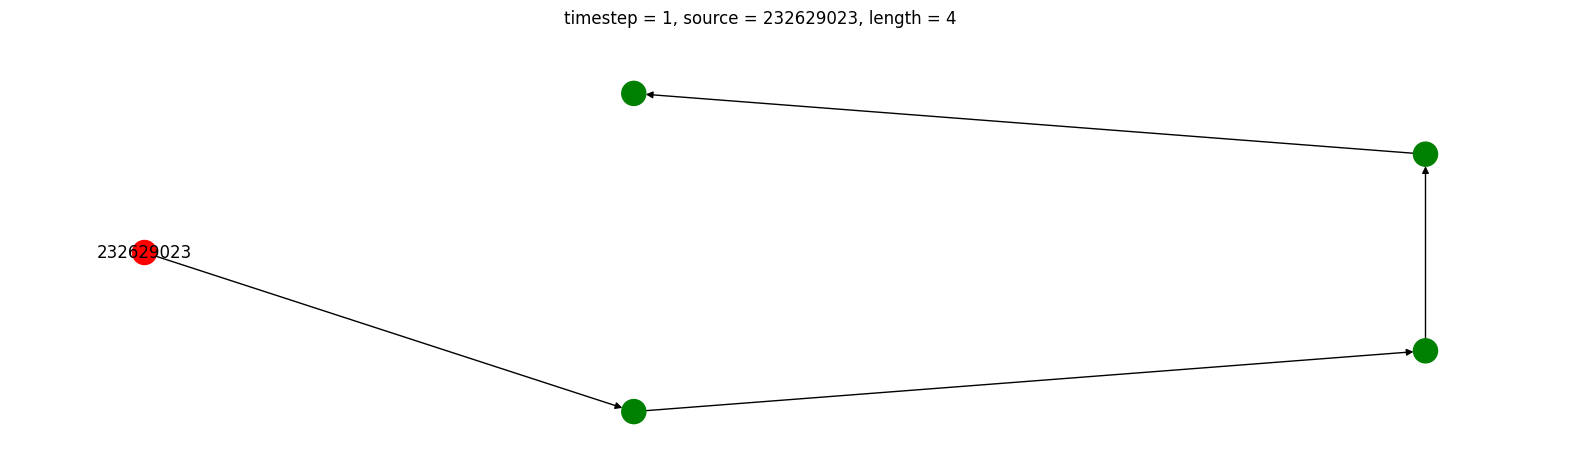

In [43]:
fig,ax = plot_bfs(G,232629023)
fig.savefig(FOLDERNAME+f'transaction_graph_{232629023}')

In [36]:
# Setup trans ID to node ID mapping
def temporal_split(t = 1):
    import torch
    df_merge = df_features.merge(df_classes, how='left', left_on=0, right_on="txId")
    df_merged_edges = df_edges.merge(df_features[[0,1]],how='left',left_on='txId1',right_on=0)

    # ---- #
    NODE_ID_COL,TIMESTEP_COL = 0,1
    df = df_merge[df_merge[TIMESTEP_COL] == t]
    df = df.sort_values(0).reset_index(drop=True)

    nodes = df[NODE_ID_COL].values
    node_to_id = {j:i for i,j in enumerate(nodes)}

    edges = df_merged_edges[df_merged_edges[TIMESTEP_COL] == t]
    edges = edges.drop(columns=[NODE_ID_COL,TIMESTEP_COL])
    edges.txId1 = edges.txId1.map(node_to_id)
    edges.txId2 = edges.txId2.map(node_to_id)
    edge_index = torch.tensor(edges.values.astype(int)).T.long().contiguous() # create a tensor

    # set all edge weights to be 1
    weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.double)
    
    labels = df['class'].values

    # mapping txIds to corresponding indices, to pass node features to the model
    node_features = df.drop(['txId'], axis=1).copy()
    transID_to_nodeID = lambda: node_features[NODE_ID_COL].map(node_to_id)
    node_features[NODE_ID_COL] = transID_to_nodeID()

    # Retain known vs unknown ID
    classified_idx = node_features['class'][node_features['class']!=2].index
    unclassified_idx = node_features['class'][node_features['class']==2].index

    classified_illicit_idx = node_features['class'][node_features['class']==1].index
    classified_licit_idx = node_features['class'][node_features['class']==0].index
    
    node_features = node_features.drop(columns=[NODE_ID_COL, TIMESTEP_COL, 'class'])

    node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)

    
    from torch_geometric.data import Data, DataLoader
    data = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, 
                                y=torch.tensor(labels, dtype=torch.double))
    # Add in the train and valid idx
    data.id_to_node = {j:i for i,j in node_to_id.items()}
    data.classified_idx = classified_idx
    data.classified_illicit_idx = classified_illicit_idx
    data.classified_licit_idx = classified_licit_idx
    data.unclassified_idx = unclassified_idx
    
    return data

In [60]:
def plot_graph(data,time_period=None):
    id_to_node = data.id_to_node
    edge_index = data.edge_index.cpu().numpy().T

    node_color = []
    for node_id in id_to_node.keys():
        if node_id in data.classified_illicit_idx:
            label = "red" # fraud
        elif node_id in data.classified_licit_idx:
            label = "green" # fraud
        else:
            label = "gray"
        node_color.append(label)
    
    # Setup networkx graph
    G = nx.DiGraph()
    G.add_edges_from(edge_index)

    # Plot the graph
    plt.figure(3,figsize=(16,16)) 
    plt.title("Time period:"+str(time_period))
    # spring layout
    nx.draw_networkx(G, node_color=node_color, node_size=20, 
                     with_labels=False,arrowsize=5)
    
    # Create a custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red','green','gray']]
    plt.legend(legend_elements, ['illicit','licit','unclassified'])

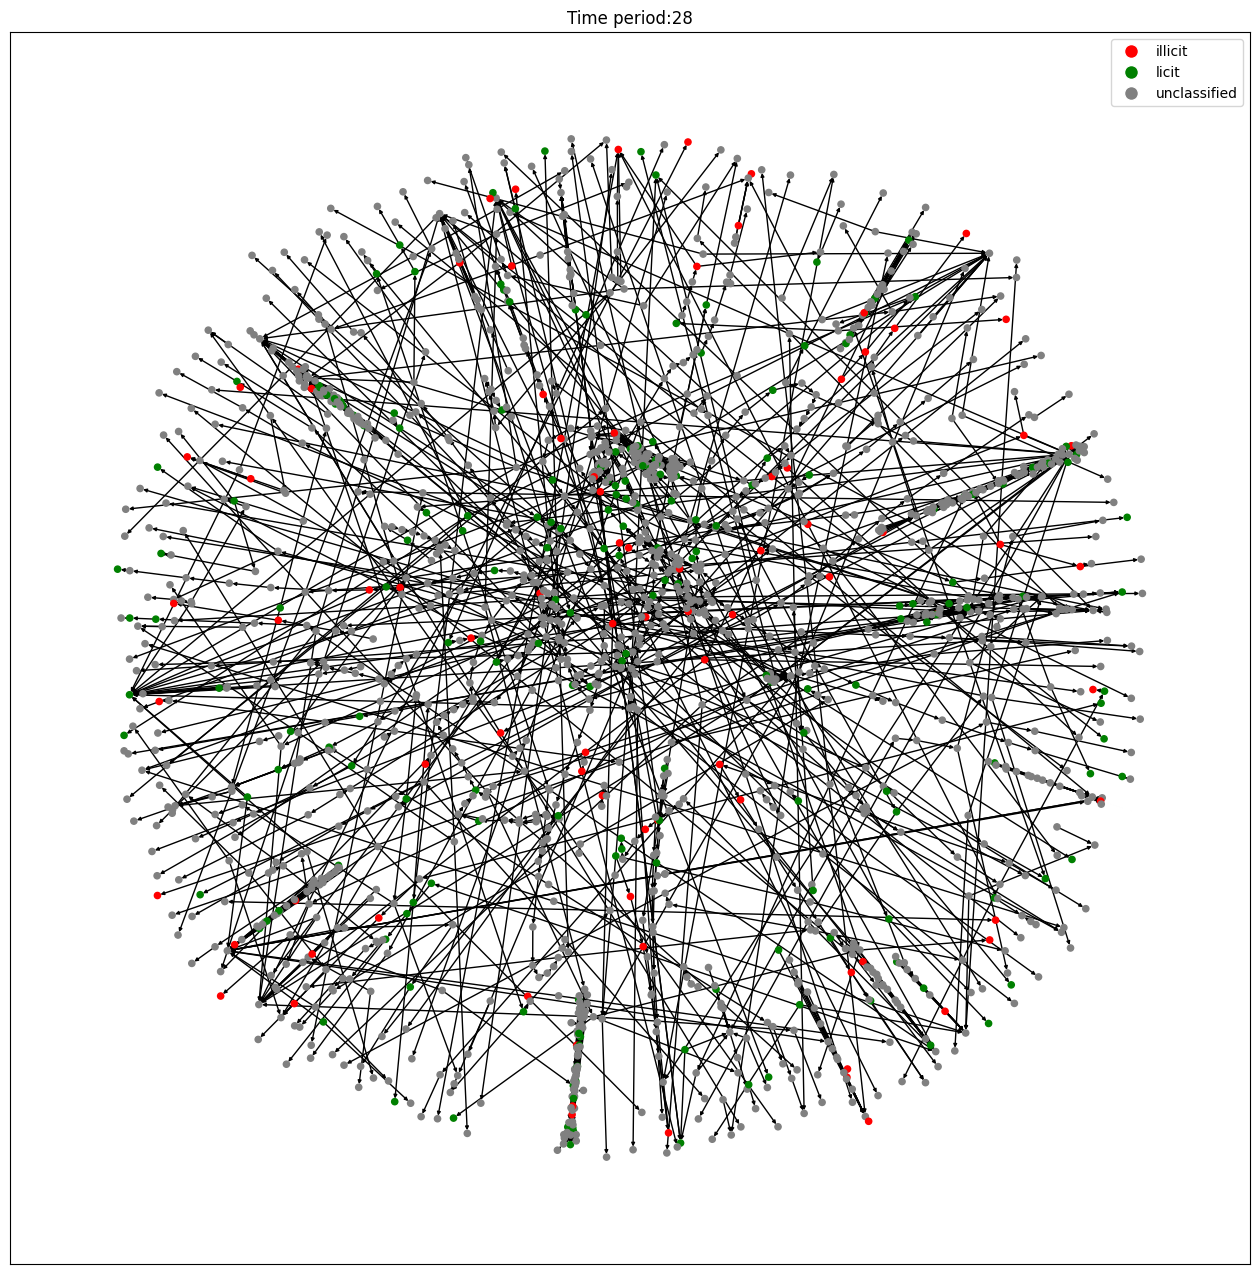

In [61]:
time_period = 28
data = temporal_split(time_period)
plot_graph(data,time_period)